# POINT objects and hulls with 🌲 Perth city trees 🌳

- Lets look at a POINT dataset
  - Our data is [Trees in the city](https://catalogue.data.wa.gov.au/dataset/perth-trees-in-the-city)
- and explore some useful algorithms:
  - convex and concave hulls
  - plotting colours 🌈
  - distance to hub (maybe)

In [69]:
# the usual suspects
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# geopandas for geospatial muning and visuals
import geopandas as gpd
# library for accessing map raster tiles
import contextily as ctx
# shapely objects and tools
from shapely.geometry import Point

# import the data
city_trees = gpd.read_file('./../data/Trees_in_the_City.geojson')

OBJECTID  TREE_ID              DATE_PLANTED SUBURB  \
0         1     1918 2007-08-08 00:00:00+00:00  PERTH   
1         3     1920 1900-01-01 00:00:01+00:00  Perth   
2         4     1921 1900-01-01 00:00:01+00:00  Perth   
3         5     1922 1900-01-01 00:00:01+00:00  Perth   
4         6     1923 1900-01-01 00:00:01+00:00  Perth   

                  BOTANICAL_NAME          COMMON_NAME         FAMILY  \
0              Quercus palustris              Pin Oak       Fagaceae   
1            Cinnamomum camphora       Camphor Laurel      Lauraceae   
2         Araucaria heterophylla  Norfolk Island Pine  Araucariaceae   
3  Ficus microcarpa var 'Hillii'            Hills Fig       Moraceae   
4  Ficus microcarpa var 'Hillii'            Hills Fig       Moraceae   

   TREE_HEIGHT RARE_SPECIES HISTORIC_SIGNIFICANCE COMMUNITY_SIGNIFICANCE  \
0          1.5           No                    No                     No   
1          NaN           No                    No                     No   
2          NaN           No                    No                     No   
3          NaN           No                    No                     No   
4          NaN           No                    No                     No   

  SIGNIFICANT_GROUP RETIRED                     geometry  
0                No    None  POINT (115.86178 -31.95858)  
1                No    None  POINT (115.86186 -31.95871)  
2                No    None  POINT (115.86168 -31.95895)  
3                No    None  POINT (115.86169 -31.95912)  
4                No    None  POINT (115.86184 -31.95901)

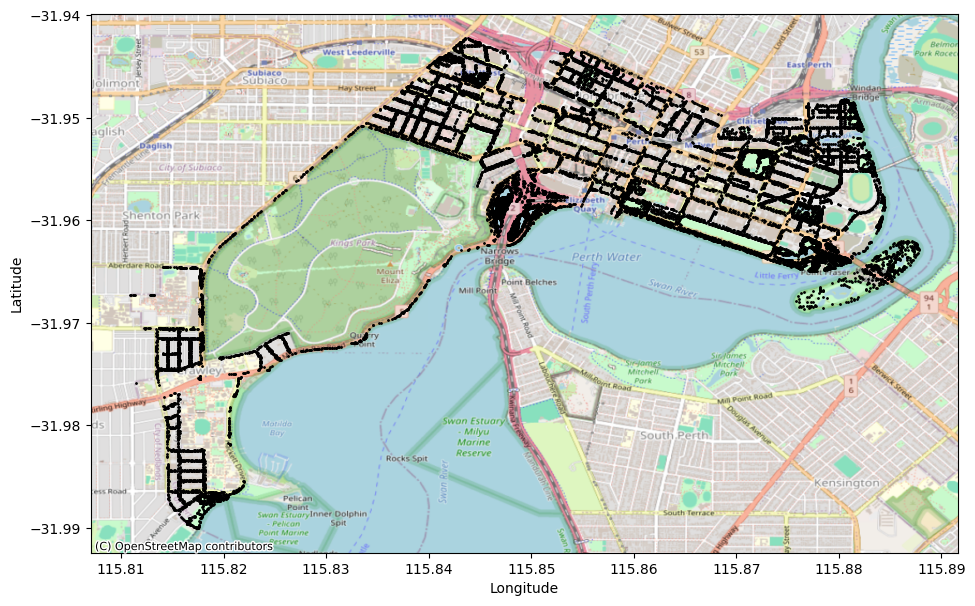

In [70]:
display(city_trees.head())

def plot_city_trees(ax
                    ,color:str|None="black"
                    ,cmap:str|None=None
                    ,column:str|None=None
                    ,trees_gdf: gpd.GeoDataFrame=city_trees):
    trees_gdf.plot(ax=ax
                ,cmap=cmap
                ,color=color
                ,column=column
                ,markersize=1)
    ctx.add_basemap(ax
        ,crs=trees_gdf.crs.to_string()
        ,source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)

fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax)

# Draw a box around those points

- Often useful to draw boxes or polygons around your points
- We have two algorithms for this:
  - `Convex hull`:
    - draw a polygon with no inny bits.
  - `Concave hull`:
    - *laise faire* convex hull with inny bits and holes.

## First, a box.

- Get the bounds from the geopandas object. Draw a polygon and plot it.

<Axes: xlabel='Longitude', ylabel='Latitude'>

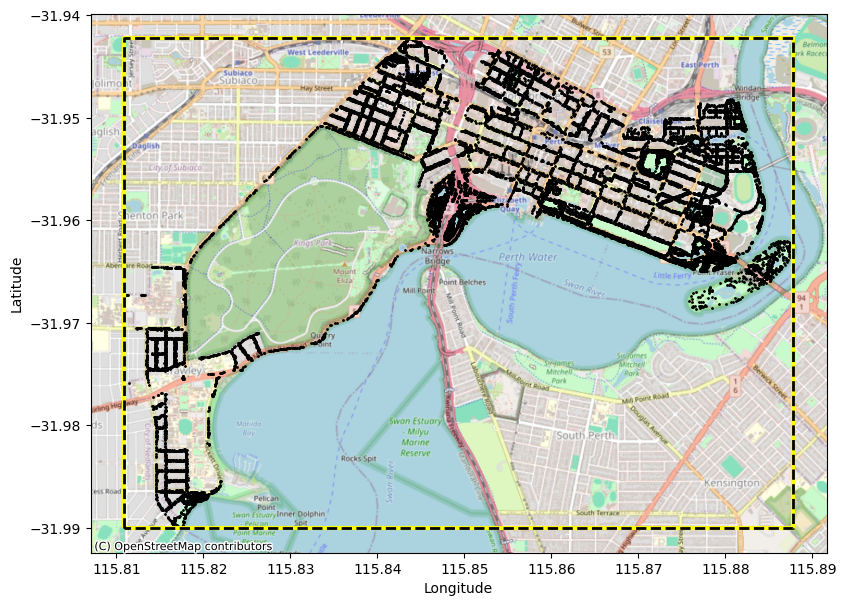

In [71]:
from shapely.geometry import Polygon # need a polygon here

bounds = city_trees.total_bounds
city_trees_box = Polygon([(bounds[0], bounds[1]),
                        (bounds[0], bounds[3]),
                        (bounds[2], bounds[3]),
                        (bounds[2], bounds[1])])
# convert to geodataframe for plotting
city_trees_box_gdf = gpd.GeoDataFrame(geometry=[city_trees_box], crs=city_trees.crs)

fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax)
city_trees_box_gdf.boundary.plot(ax=ax
                                ,color='yellow'
                                ,linewidth=3)
city_trees_box_gdf.boundary.plot(ax=ax
                                ,color='black'
                                ,linewidth=2
                                ,linestyle='dashed')

## Convex Hull

- We use `unary_union` here to combine all the points together.
- Otherwise it will do a convex hull for every point seperately...

<Axes: xlabel='Longitude', ylabel='Latitude'>

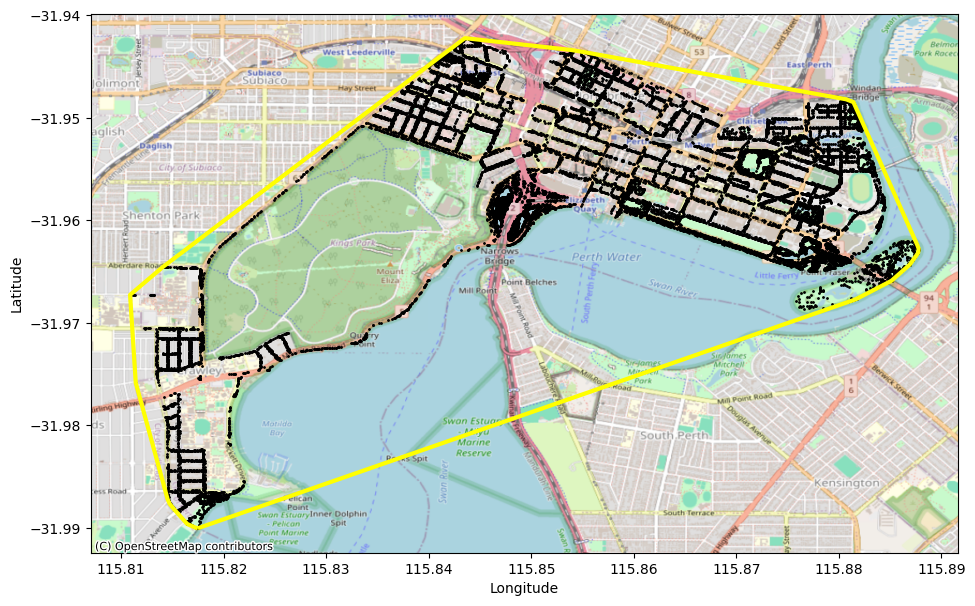

In [72]:
city_trees_hull = city_trees.unary_union.convex_hull
fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax)
gpd.GeoSeries([city_trees_hull]).boundary.plot(ax=ax, color='yellow', linewidth=3)

- And we can use groupby to do the hull by each suburb.
- Checkout some of the weird suburbs in there... 😂
  - And the Crawley hull is a little bit suspect 🤔

/tmp/ipykernel_26311/4048449099.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.geometry.unary_union.convex_hull))


<Axes: xlabel='Longitude', ylabel='Latitude'>

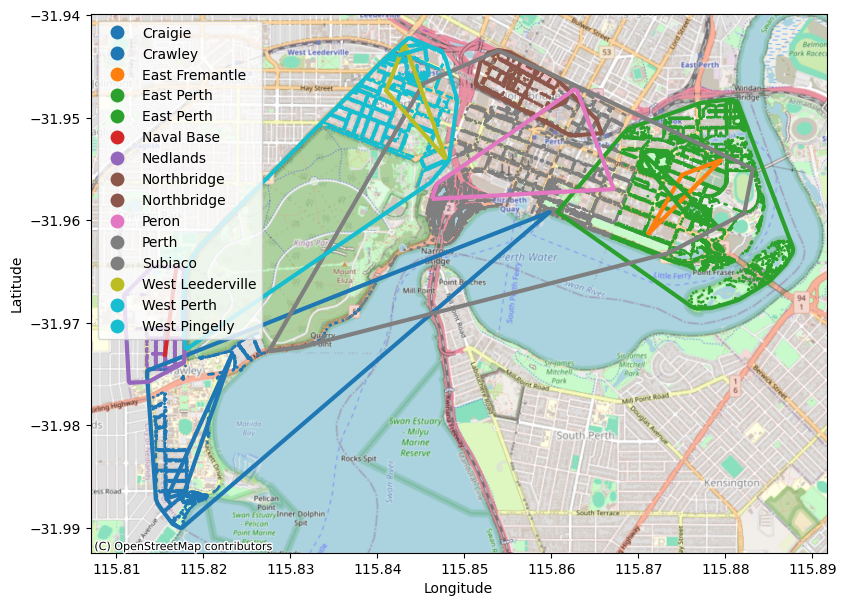

In [73]:
city_trees["SUBURB"] = city_trees["SUBURB"].str.title()
convex_rare_species = (
    city_trees
    .groupby("SUBURB")
    .apply(lambda df: df.geometry.unary_union.convex_hull))

convex_rare_species_gdf = gpd.GeoDataFrame(
    geometry=convex_rare_species
    ,crs=city_trees.crs) # type: ignore
convex_rare_species_gdf.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax,column="SUBURB",color=None)
convex_rare_species_gdf.plot(column="SUBURB"
                            ,facecolor="none"
                            ,legend=True
                            ,legend_kwds={'loc': 'upper left'}
                            ,linewidth=3
                            ,ax=ax)

# Concave Hull

⚠️ spicy danger zone 🌶️

- Concave hull allows for more complex groupings
- But can produce some consequences.
- `concave_hull` also acts on each row and not the whole df.
- So we have to get the union of all points and get that polygon
- `ratio` is the argument of interest here:
  - as we decrease ratio the concave hull gets "more concave"
  - but the splits between hulls become a bit strange...

<Axes: xlabel='Longitude', ylabel='Latitude'>

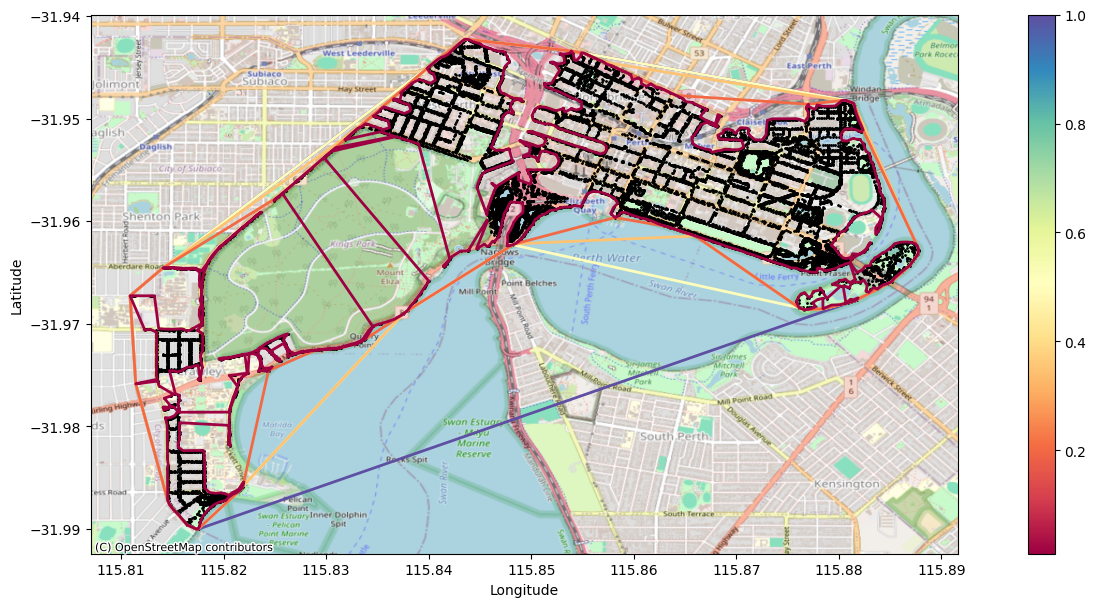

In [74]:
all_city_trees_points = city_trees.unary_union
all_city_trees_points_gdf = gpd.GeoDataFrame(
    geometry=[all_city_trees_points]
    ,crs=city_trees.crs) # type: ignore
concave_polys = []
ratios = [1,0.5,0.35,0.2,0.01]
for i in ratios:
    concave_polys.append(
        all_city_trees_points_gdf.concave_hull(ratio=i)[0])
concave_polys_gdf = gpd.GeoSeries(concave_polys).to_frame()
concave_polys_gdf["ratio"] = ratios

fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax)
concave_polys_gdf.plot(column="ratio"
                        ,facecolor="none"
                        ,legend=True
                        ,cmap="Spectral"
                        ,linewidth=2
                        ,ax=ax)

In [75]:
city_trees["geometry"].concave_hull()

0        POINT (115.86178 -31.95858)
1        POINT (115.86186 -31.95871)
2        POINT (115.86168 -31.95895)
3        POINT (115.86169 -31.95912)
4        POINT (115.86184 -31.95901)
                    ...             
16470    POINT (115.81452 -31.97966)
16471    POINT (115.84045 -31.95043)
16472    POINT (115.84060 -31.95047)
16473    POINT (115.87353 -31.96293)
16474    POINT (115.87334 -31.96324)
Length: 16475, dtype: geometry

# Distance to hub

- How far are these trees from where we *right now*!
- Protip: you can get the coordinates in lat,lons from google maps URLS:
  - https://www.google.com.au/maps/place//@-31.9557179,115.8588269,21z?entry=ttu

<Axes: xlabel='Longitude', ylabel='Latitude'>

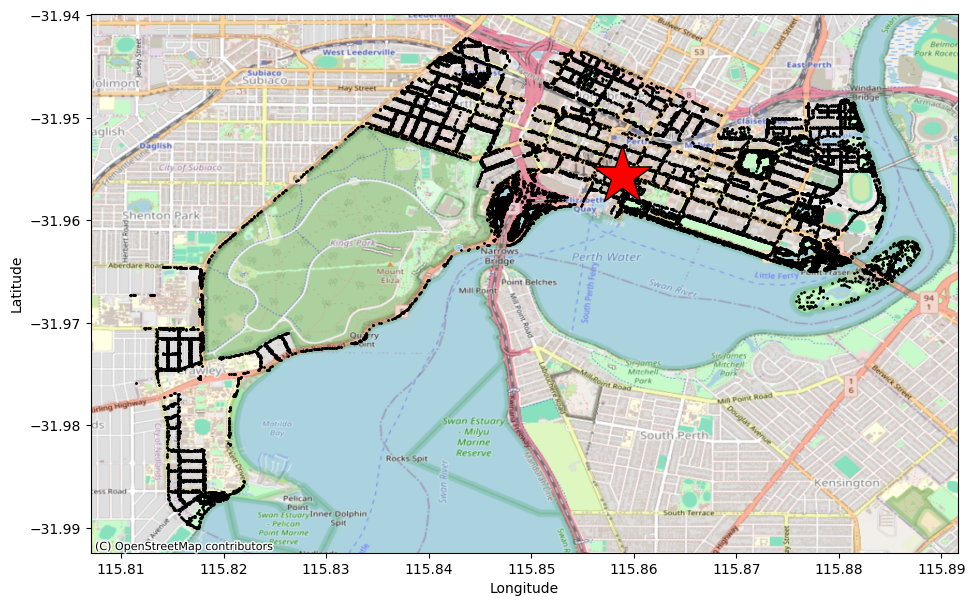

In [76]:
spacecubed_wgs84 = (115.8588269,-31.9557179)
spacecubed = Point(spacecubed_wgs84)
fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax)
gpd.GeoSeries([spacecubed]).plot(ax=ax
                                ,color='red'
                                ,markersize=2e3
                                ,marker='*'
                                ,edgecolor='black')

We can distance easily... but what's that `UserWarning`?

And what do you mean the largests distances are 0.05... whats?

It's in `degrees`! We have distances in degrees 🙃

In [77]:
# distance from tree to spacecubed
city_trees["distance_to_spacecubed"] = city_trees.distance(spacecubed)
city_trees["distance_to_spacecubed"].sort_values(ascending=False).head()

/tmp/ipykernel_26311/36200453.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_trees["distance_to_spacecubed"] = city_trees.distance(spacecubed)


7864    0.054438
7865    0.054429
7866    0.054427
7867    0.054416
7868    0.054414
Name: distance_to_spacecubed, dtype: float64

```
UserWarning: Geometry is in a geographic CRS.
Results from 'distance' are likely incorrect.
Use 'GeoSeries.to_crs()' to re-project geometries
to a projected CRS before this operation.
```


- This is a good time to switch to a different `CRS` (coordinate reference system).
- We will use the GDA2020 scheme developed by the Aust Government.
  - [See here](https://www.icsm.gov.au/gda2020)
- The 2020 essentially means "correct as of 2020". Blame plate tectonics.
- The GDA2020 is referenced back to WGS84 (lats and lons).
- But depending on the math, some use meters as their unit of measurement.
- Typically a bit more accurate than WGS84 too!

- Specifically, we will use GDA2020 UTM Zone 50.
  - We use the EPSG catalog number for it: [EPSG:7850](https://epsg.io/7850)
  - ignore the map in the link, it's wrong, UTM Zone 50 only coves a little rectangle of the world:

![UTM](./../data/wikipedia_utm_zones.png)

And the code to do this:

- 5491 meters from the furthest tree makes sense!
- The closest trees are about 17 meters away out on the street.

In [78]:
from pyproj import Transformer

# geopandas makes this easy for city_trees
city_trees_gda2020 = city_trees.to_crs(epsg=7850)

# we use pyproj,Transformer for spacecubed
wgs84_to_epsg7850 = Transformer.from_crs(4326, 7850)
spacecubed_gda2020 = gpd.GeoSeries([spacecubed], crs="EPSG:4326").to_crs(epsg=7850).values[0]
city_trees_gda2020["distance_to_spacecubed"] = city_trees_gda2020.distance(spacecubed_gda2020)

display(
    city_trees_gda2020["distance_to_spacecubed"].sort_values(ascending=False).head(2)
    ,city_trees_gda2020["distance_to_spacecubed"].sort_values(ascending=False).tail(2))

8352    5491.166918
8346    5490.757280
Name: distance_to_spacecubed, dtype: float64

13227    21.776706
13226    17.979481
Name: distance_to_spacecubed, dtype: float64

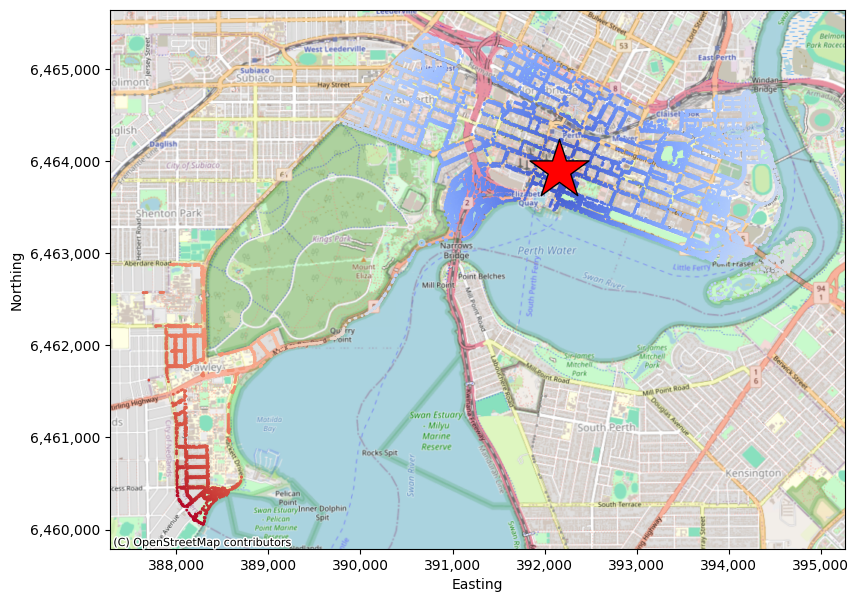

In [79]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(18,7))
city_trees_gda2020.plot(
                ax=ax
                ,markersize=1
                ,column="distance_to_spacecubed"
                ,cmap="coolwarm")
gpd.GeoSeries([spacecubed_gda2020]).plot(ax=ax
                                ,color='red'
                                ,markersize=2e3
                                ,marker='*'
                                ,edgecolor='black')
ctx.add_basemap(ax
                ,crs=city_trees_gda2020.crs.to_string()
                ,source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
# get rid of trash scientific notation ♻️
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))